# 21點樸克牌(Blackjack)之策略評估

In [1]:
# 載入相關套件
import numpy as np
from lib.envs.blackjack import BlackjackEnv
from lib import plotting
import sys
from collections import defaultdict
import matplotlib

matplotlib.style.use('ggplot') # 設定繪圖的風格

In [2]:
# 環境
env = BlackjackEnv()

In [3]:
# 試玩
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print(f"玩家分數: {score} (是否持有A: {usable_ace}), 莊家分數: {dealer_score}")

def strategy(observation):
    score, dealer_score, usable_ace = observation
    # 超過20點，不補牌(stick)，否則都跟莊家要一張牌(hit)
    return 0 if score >= 20 else 1

# 試玩 20 次
for i_episode in range(20):
    observation = env.reset()
    # 開始依策略玩牌，最多 100 步驟，中途分出勝負即結束
    for t in range(100):
        print_observation(observation)
        action = strategy(observation)
        print(f'行動: {["不補牌", "補牌"][action]}')
        observation, reward, done, _ = env.step(action)
        if done:
            print_observation(observation)
            print(f"輸贏分數: {reward}\n")
            break

玩家分數: 13 (是否持有A: False), 莊家分數: 3
行動: 補牌
玩家分數: 19 (是否持有A: False), 莊家分數: 3
行動: 補牌
玩家分數: 24 (是否持有A: False), 莊家分數: 3
輸贏分數: -1

玩家分數: 15 (是否持有A: False), 莊家分數: 10
行動: 補牌
玩家分數: 25 (是否持有A: False), 莊家分數: 10
輸贏分數: -1

玩家分數: 15 (是否持有A: False), 莊家分數: 8
行動: 補牌
玩家分數: 20 (是否持有A: False), 莊家分數: 8
行動: 不補牌
玩家分數: 20 (是否持有A: False), 莊家分數: 8
輸贏分數: 1

玩家分數: 19 (是否持有A: False), 莊家分數: 10
行動: 補牌
玩家分數: 27 (是否持有A: False), 莊家分數: 10
輸贏分數: -1

玩家分數: 20 (是否持有A: False), 莊家分數: 4
行動: 不補牌
玩家分數: 20 (是否持有A: False), 莊家分數: 4
輸贏分數: 1

玩家分數: 15 (是否持有A: False), 莊家分數: 1
行動: 補牌
玩家分數: 22 (是否持有A: False), 莊家分數: 1
輸贏分數: -1

玩家分數: 19 (是否持有A: False), 莊家分數: 10
行動: 補牌
玩家分數: 25 (是否持有A: False), 莊家分數: 10
輸贏分數: -1

玩家分數: 15 (是否持有A: False), 莊家分數: 9
行動: 補牌
玩家分數: 23 (是否持有A: False), 莊家分數: 9
輸贏分數: -1

玩家分數: 15 (是否持有A: False), 莊家分數: 10
行動: 補牌
玩家分數: 21 (是否持有A: False), 莊家分數: 10
行動: 不補牌
玩家分數: 21 (是否持有A: False), 莊家分數: 10
輸贏分數: 0

玩家分數: 20 (是否持有A: False), 莊家分數: 2
行動: 不補牌
玩家分數: 20 (是否持有A: False), 莊家分數: 2
輸贏分數: 1

玩家分數: 20 (是否持有A: False), 莊家分數: 4
行動: 不補牌


In [4]:
# 策略評估函數
def policy_eval(policy, env, num_episodes, discount_factor=1.0):
    returns_sum = defaultdict(float)    # 記錄每一個狀態的報酬
    returns_count = defaultdict(float)  # 記錄每一個狀態的訪問個數
    V = defaultdict(float) # 狀態值函數
    
    # 實驗 N 回合
    for i_episode in range(1, num_episodes + 1):
        # 每 1000 回合顯示除錯訊息
        if i_episode % 1000 == 0:
            print(f"\r {i_episode}/{num_episodes}回合.", end="")
            sys.stdout.flush() # 清除畫面

        # 回合(episode)資料結構為陣列，每一項目含 state, action, reward
        episode = []
        state = env.reset()
        # 開始依策略玩牌，最多 100 步驟，中途分出勝負即結束
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # 找出走過的所有狀態
        states_in_episode = set([tuple(x[0]) for x in episode])
        # 計算每一狀態的值函數
        for state in states_in_episode:
            # 找出每一步驟內的首次訪問(First Visit)
            first_occurence_idx = next(i for i,x in enumerate(episode) 
                                       if x[0] == state)
            # 算累計報酬(G)
            G = sum([x[2]*(discount_factor**i) for i,x in 
                     enumerate(episode[first_occurence_idx:])])
            # 計算狀態值函數
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V    

In [5]:
# 採相同策略
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    # 超過20點，不補牌(stick)，否則都跟莊家要一張牌(hit)
    return 0 if score >= 20 else 1

 10000/10000回合.

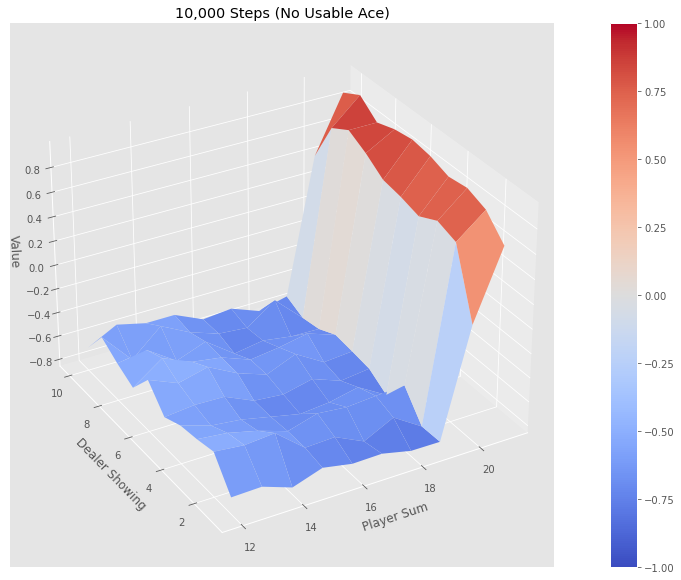

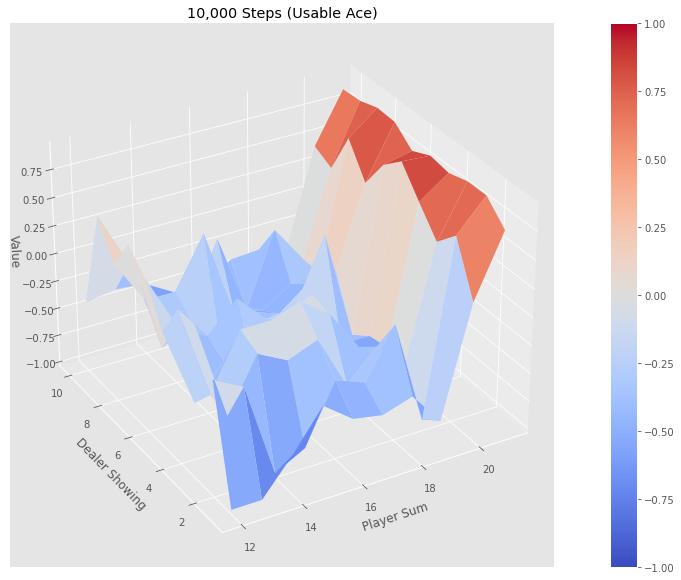

 500000/500000回合.

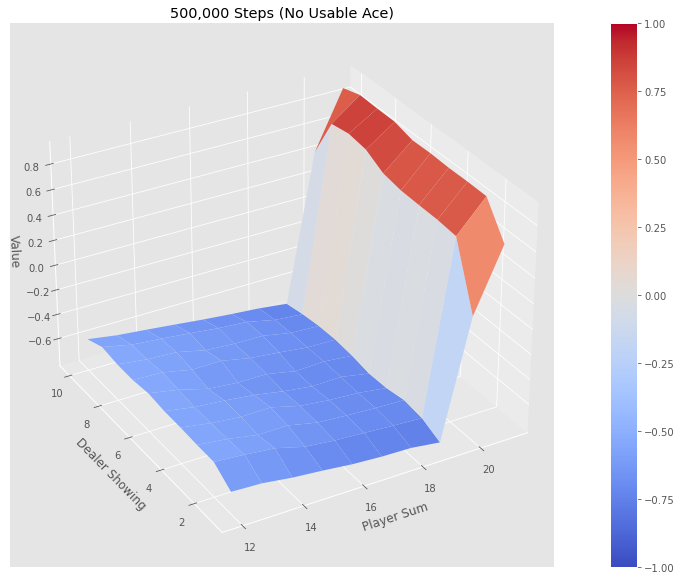

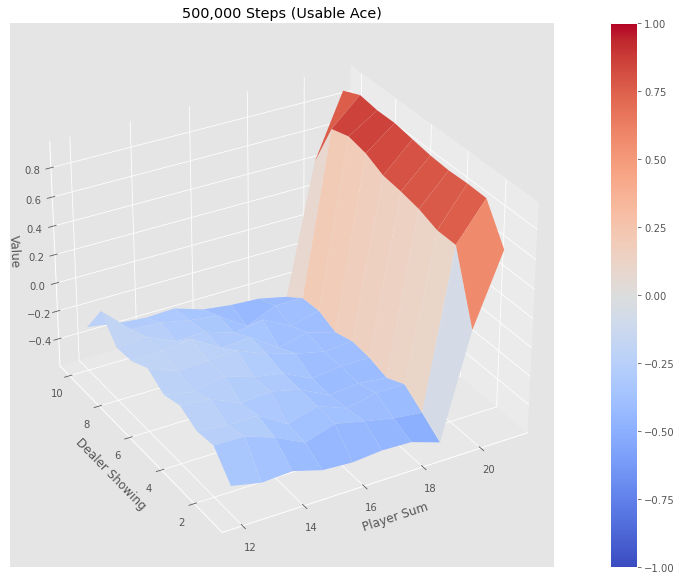

In [6]:
# 實驗 10000 回合
V_10k = policy_eval(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

# 實驗 500,000 回合
V_500k = policy_eval(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")